In [13]:
import numpy as np
import sympy as sp
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Load the data 
class_1_data = np.load('class1.npy') # label 0 
class_2_data = np.load('class2.npy') # label 1 

#Built a numpy array 
X = np.concatenate((class_1_data,class_2_data))

# True label array 
T = []
for n in range(0, len(X)):
    if (n < len(class_1_data)):
        T.append(0)
    else:
        T.append(1)

In [3]:
def print_matrix (W1,b1,W2,b2):
    # Convert to sympy matric for proper display the matric of the generated weights and bias terms 
    W1_mat = sp.Matrix(W1)
    b1_mat = sp.Matrix(b1)
    W2_mat = sp.Matrix(W2)
    b2_mat = sp.Matrix(b2)
    
    y_prob = forward(X,W1,W2,b1,b2)
    print("W^(1) =")
    sp.pprint(W1_mat, use_unicode = True)
    print("\nb^(1) =")
    sp.pprint(b1_mat, use_unicode=True)
    print("\nW^(2) =")
    sp.pprint(W2_mat, use_unicode=True)
    print("\nb^(2) =")
    sp.pprint(b2_mat, use_unicode=True)

def print_mlp_expressions(W1, b1, W2, b2, feature_names=None, decimals=3, act_symbol='σ'):
    """
    Pretty-prints math-style expressions for a 2-layer MLP:
        input (D) -> hidden (H) -> output (O)
    using sigmoid notation 'σ' by default.

    Args
    ----
    W1 : (D, H) array  input->hidden weights
    b1 : (H,)   array  hidden biases
    W2 : (H, O) array  hidden->output weights
    b2 : (O,)   array  output biases
    feature_names : list[str] of length D (optional). Default: x1, x2, ...
    decimals : int  number of decimals in coefficients
    act_symbol : str activation symbol to print (e.g., 'σ' or 'sigmoid')

    Returns
    -------
    dict with lists of strings for z1, h, z2, yhat (also printed).
    """
    W1 = np.asarray(W1); b1 = np.asarray(b1)
    W2 = np.asarray(W2); b2 = np.asarray(b2)

    D, H = W1.shape
    assert b1.shape == (H,), "b1 must be shape (H,)"
    H2, O = W2.shape
    assert H2 == H, "W2 must have same hidden size as W1 second dim"
    assert b2.shape == (O,), "b2 must be shape (O,)"

    # Feature names
    if feature_names is None:
        feature_names = [f"x{i+1}" for i in range(D)]

    def coef(x):  # format with sign and rounding
        return f"{x:+.{decimals}f}"

    lines_z1, lines_h = [], []
    print("\nHidden layer pre-activations z^(1):")
    z1_vec_parts = []
    for j in range(H):
        terms = [f"{coef(W1[i, j])}*{feature_names[i]}" for i in range(D)]
        expr = " + ".join(terms) + f" {coef(b1[j])}"
        lines_z1.append(f"z1_{j+1} = {expr}")
        z1_vec_parts.append(expr)
        print(" ", lines_z1[-1])
    print("\nHidden activations h = σ(z^(1)):")
    for j in range(H):
        lines_h.append(f"h{j+1} = {act_symbol}(z1_{j+1})")
        print(" ", lines_h[-1])

    print("\nOutput layer pre-activations z^(2):")
    lines_z2, lines_y = [], []
    for k in range(O):
        terms = [f"{coef(W2[j, k])}*h{j+1}" for j in range(H)]
        expr = " + ".join(terms) + f" {coef(b2[k])}"
        lines_z2.append(f"z2_{k+1} = {expr}")
        print(" ", lines_z2[-1])
    print("\nFinal outputs ŷ = σ(z^(2)):")
    for k in range(O):
        lines_y.append(f"ŷ{k+1} = {act_symbol}(z2_{k+1})")
        print(" ", lines_y[-1])

    return {"z1": lines_z1, "h": lines_h, "z2": lines_z2, "yhat": lines_y}


In [4]:
# Function to plot the original data 
def plot_data_with_labels(X, y):

    plt.figure(figsize=(7,6))
    plt.grid(True, alpha=0.3)

    # scatter by true label
    plt.scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k", s=45)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Ground Truth Data")
    plt.show()

In [66]:
# Q2 

### Condition ###############################
# Multi-Layer Perceptron (MLP) 2-3-1 
# Using sigmoid as activation function
# W1*X + b1 @ using normal distribution to randomly generate [mean = 0 , sigma = 0.1]
mu = 0 # mean for using normal distribution 
sigma = 0.1 # std deviation for using normal distribution 
threshold = 0.5 # threshold for discriminat class 1 or 2 

# Random weight ( 9 connections ) 

# Function to generate weight 
def generate_weight(x,cov,size_weight):
    rng = np.random.default_rng() # Declare a random object 
    W = rng.normal(x,cov,size=size_weight) # Weight term 
    B = rng.normal(x,cov,size=(size_weight[1],)) # Bias term 
    return W,B
    
# Activation function 
def sigmoid(z): 
    return 1/(1+np.exp(-z))

# Sigmoid derivative function 
def sigmoid_deriv(x):
    s = sigmoid(x)
    return s*(1-s)
    
# Feed forward function (One layer inputs + one hidden layer + one output layer)
def forward(X,W1,W2,b1,b2):
    z1 = X @ W1 + b1  # Input to hidden layer 
    h1 = sigmoid(z1) 
    z2 = h1 @ W2 + b2
    y = sigmoid(z2).ravel()
    return y,z1,h1,z2 

# Backpropagation function 
def backpropagation(X,T, W1, b1, W2, b2, eta=0.1, epochs=1):
    N = X.shape[0] # get the dimension of the input data
    T = np.array(T).reshape(-1,1)
    error_array = []

    for epoch in range(epochs):
        # pass the forward function 
        y, z1, h1, z2 = forward(X,W1,W2,b1,b2)
        y_predict = (y > threshold).astype(int)
        y_predict = y_predict.reshape(-1,1)

        # LSE 
        loss = np.mean(y_predict-T)**2
        error_array.append(loss)
        
        # loss function (Using Squared error)
        error = (y_predict - T)
    
        # Perform backward propagation 
        delta2 = error*sigmoid_deriv(z2)
        dW2 = h1.T @ delta2 / N # matrix multiplication 
        db2 = delta2.mean(axis=0)

        delta1 = (delta2 @ W2.T) * sigmoid_deriv(z1)
        dW1 = X.T @ delta1 / N
        db1 = delta1.mean(axis=0)
        # update 
        W2 = W2 - eta * dW2
        b2 = b2 - eta * db2
        W1 = W1 - eta * dW1
        b1 = b1 - eta * db1
    return W1, W2, b1, b2, error_array       


# Function to plot the decision boundary with using contour  
def plot_decision_boundary(X,W1, W2, b1, b2):
    plt.figure(figsize=(7,6))
    plt.grid(True, alpha=0.3)

    # Build mesh grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Forward pass on grid (reuse forward function)
    zz = forward(grid, W1, W2, b1, b2)[0].reshape(xx.shape)
    
    # Plot the decision boundary
    Z =  (zz > threshold).astype(int)
    # Plot decision regions with blue (class_0) and yellow (class_1)
    cmap_contour = mcolors.ListedColormap(["#add8e6", "yellow"])
    # Plot the contour
    plt.contourf(xx,yy,Z,cmap=cmap_contour)

    # Plot the orignal data points with green (class_0) and red (class_1)
    cmap_original = mcolors.ListedColormap(["green", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=T, cmap=cmap_original)

    # legend settings
    legend_handles = [
        mpatches.Patch(color="#add8e6", label="Predicted region class 0"),
        mpatches.Patch(color="yellow",   label="Predicted region class 1"),
        mpatches.Patch(color="green", label="Class 0"),
        mpatches.Patch(color="red",   label="Class 1"),
    ]
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.legend(handles=legend_handles, loc="best")
    plt.show()

def plot_ROC_function(T,y_pred):
    fpr, tpr, thr = roc_curve(T, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)

def plot_loss_function(loss_array):
    plt.figure()
    plt.plot(loss_array)
    plt.xlabel("Epoch")
    plt.ylabel("MSE_Loss")
    plt.title("Training Loss")
    plt.show()

In [7]:
# Obtain the weight and bias term from random generator (normal distribution) 
W1,b1 = generate_weight(mu,sigma,(2,3)) # first layer is 2x3 
W2,b2 = generate_weight(mu,sigma,(3,1)) # second layer is 3x1 
print(b1)

[-0.12765122 -0.20020056  0.03639546]



Hidden layer pre-activations z^(1):
  z1_1 = +0.090*x1 + -0.067*x2 -0.128
  z1_2 = +0.097*x1 + +0.046*x2 -0.200
  z1_3 = +0.072*x1 + +0.166*x2 +0.036

Hidden activations h = σ(z^(1)):
  h1 = σ(z1_1)
  h2 = σ(z1_2)
  h3 = σ(z1_3)

Output layer pre-activations z^(2):
  z2_1 = +0.058*h1 + +0.064*h2 + +0.228*h3 -0.043

Final outputs ŷ = σ(z^(2)):
  ŷ1 = σ(z2_1)
40000


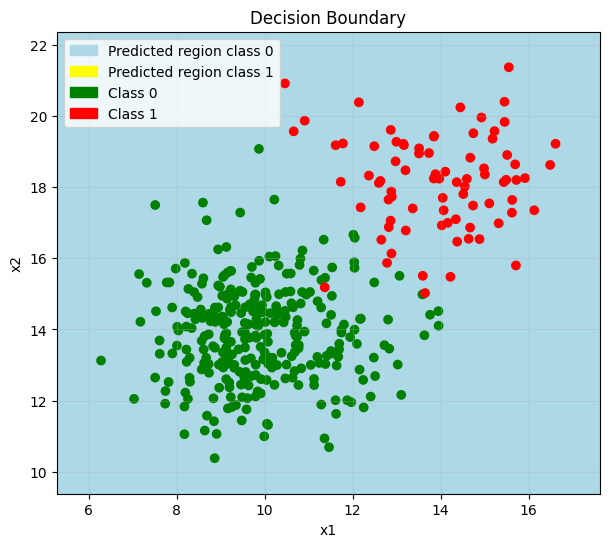

[[  0 300]
 [  0  80]]
Accuracy : 0.21052631578947367
Precision: 0.21052631578947367
Recall   : 1.0


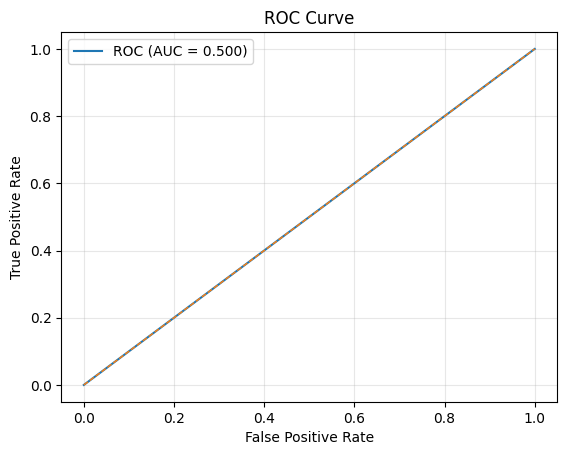

In [65]:
# Before Back_Propagation 
print_mlp_expressions(W1, b1, W2, b2, feature_names=["x1","x2"])
y_prob,z1,h1,z2  = forward(X,W1,W2,b1,b2)
y_pred = (y_prob > threshold).astype(int)
plot_decision_boundary(X, W1, W2,b1, b2)
plot_ROC_function(T,y_pred)
print(confusion_matrix(T,y_pred))
print("Accuracy :", accuracy_score(T, y_pred)) # Calculate accuracy score
print("Precision:", precision_score(T, y_pred, zero_division=0)) # Calculate precison 
print("Recall   :", recall_score(T, y_pred, zero_division=0)) # Calculate Recall

########

Hidden layer pre-activations z^(1):
  z1_1 = +0.081*x1 + -0.079*x2 -0.129
  z1_2 = +0.092*x1 + +0.039*x2 -0.201
  z1_3 = +0.063*x1 + +0.155*x2 +0.036

Hidden activations h = σ(z^(1)):
  h1 = σ(z1_1)
  h2 = σ(z1_2)
  h3 = σ(z1_3)

Output layer pre-activations z^(2):
  z2_1 = +0.017*h1 + -0.009*h2 + +0.141*h3 -0.136

Final outputs ŷ = σ(z^(2)):
  ŷ1 = σ(z2_1)


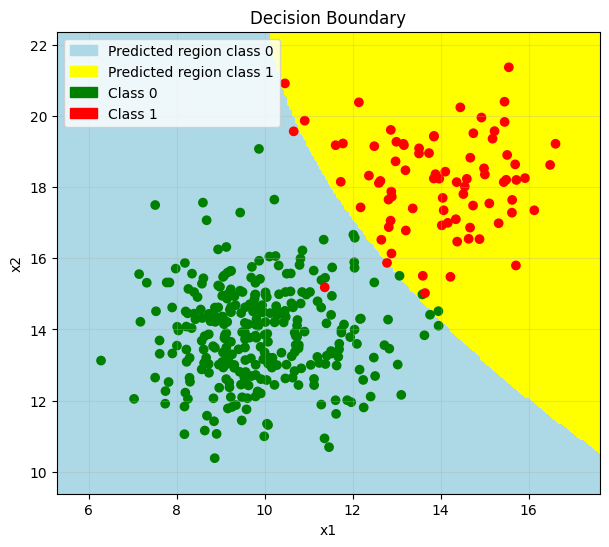

Accuracy : 0.9842105263157894
Precision: 0.9625
Recall   : 0.9625


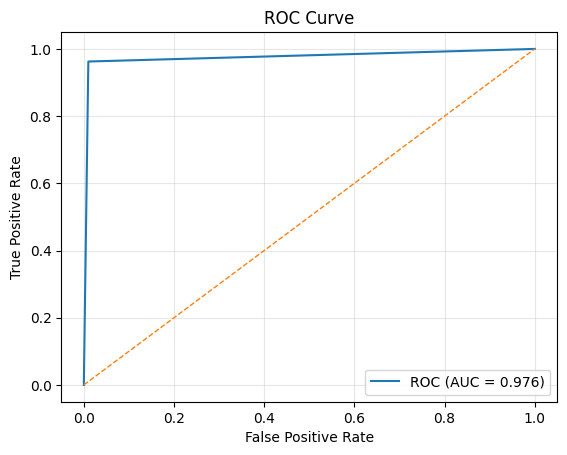

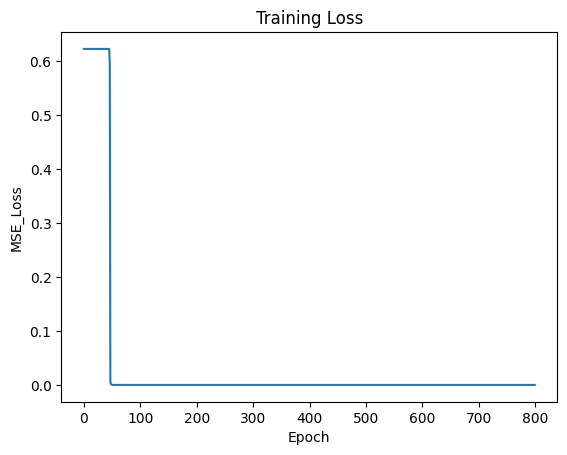

In [9]:
### BackPropagation
W1_new,W2_new,b1_new,b2_new,error_array = backpropagation(X,T, W1, b1, W2, b2, eta=0.01, epochs=800)
print("########")
print_mlp_expressions(W1_new, b1_new, W2_new, b2_new, feature_names=["x1","x2"])
y_prob,z1,h1,z2  = forward(X,W1_new,W2_new,b1_new,b2_new)
y_pred = (y_prob > threshold).astype(int)
plot_decision_boundary(X, W1_new, W2_new,b1_new, b2_new)
plot_ROC_function(T,y_pred)
print("Accuracy :", accuracy_score(T, y_pred)) # Calculate accuracy score
print("Precision:", precision_score(T, y_pred, zero_division=0)) # Calculate precison 
print("Recall   :", recall_score(T, y_pred, zero_division=0)) # Calculate Recall
plot_loss_function(error_array)

Accuracy : 0.7894736842105263
Precision: 0.0
Recall   : 0.0


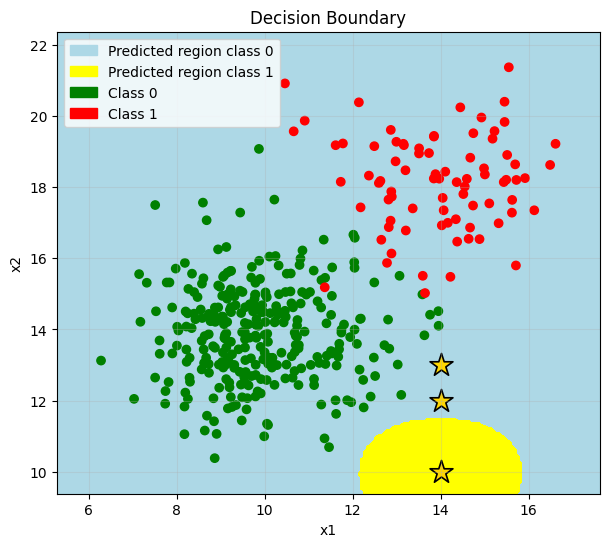

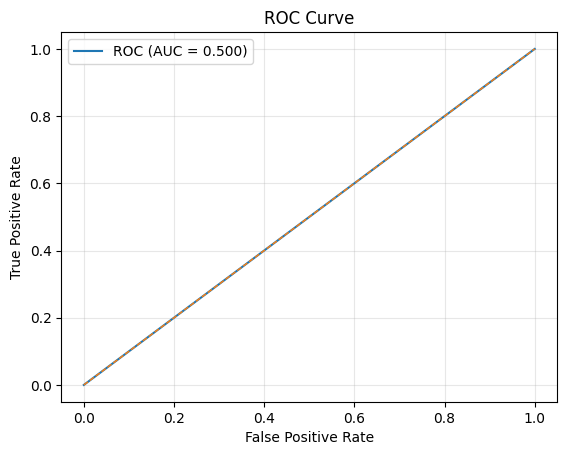

In [112]:
num_hidden = 3 # number of hidden layers
sigma = 1 

# Define the Gaussian RBF function
def rbf(x, center, spread):
    squared_distance = np.sum((x - center) ** 2)
    return np.exp(-squared_distance / (2 * spread ** 2))

# Define the centers for the RBF neurons
def random_center_generate(X, j):
    X_size = X.shape[1]  # number of features (columns)
    center_array = []
    for h in range(j):
        dummy_array = []
        for i in range(X_size):
            min_X = X[:, i].min()
            max_X = X[:, i].max()
            dummy_array.append(random.randint(int(min_X), int(max_X)))
        center_array.append(dummy_array)
    return np.array(center_array)

# Define constant spreads (all set to 5 here)
def constant_one_spread_generator(j,sigma):
    dummy_array = []
    for i in range(j):
        dummy_array.append(sigma)
    return np.array(dummy_array)

# Generate centers and spreads
centers = random_center_generate(X, num_hidden)
centers[0][0] = 14
centers[1][0] = 14
centers[2][0] = 14
spreads = constant_one_spread_generator(num_hidden,sigma)

# Compute the design matrix Phi
Phi = np.zeros((X.shape[0], centers.shape[0]))
for i, x in enumerate(X):
    for j, center in enumerate(centers):
        Phi[i, j] = rbf(x, center, spreads[j])

# Compute the weights using the normal equation
Phi_T = Phi.T
weights = np.linalg.inv(Phi_T @ Phi) @ Phi_T @ T

# Define forward function to predict outputs
def forward_rbf(x, centers, spreads, weights):
    activations_matrix = np.zeros((x.shape[0], centers.shape[0]))
    for i, x_i in enumerate(x):
        for j, center in enumerate(centers):
            activations_matrix[i, j] = rbf(x_i, center, spreads[j])
   # print(activations_matrix)
    predicted_y = activations_matrix @ weights
    return predicted_y,activations_matrix

# Function to plot the decision boundary with using contour  
def plot_decision_boundary_rbf(X,centers,spreads,weights):
    plt.figure(figsize=(7,6))
    plt.grid(True, alpha=0.3)

    # Build mesh grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = forward_rbf(grid,centers,spreads,weights)[0].reshape(xx.shape)
    
    # Plot the decision boundary
    Z =  (zz > threshold).astype(int)
    # Plot decision regions with blue (class_0) and yellow (class_1)
    cmap_contour = mcolors.ListedColormap(["#add8e6", "yellow"])
    # Plot the contour
    plt.contourf(xx,yy,Z,cmap=cmap_contour)

    # Plot the orignal data points with green (class_0) and red (class_1)
    cmap_original = mcolors.ListedColormap(["green", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=T, cmap=cmap_original)

    # highlight centers
    plt.scatter(centers[:,0], centers[:,1], marker='*', s=300, c='gold', edgecolors='k', linewidths=1.2, label="RBF centers")
    # optional σ-circles (visualize receptive field size)
    ax = plt.gca()

    # legend settings
    legend_handles = [
        mpatches.Patch(color="#add8e6", label="Predicted region class 0"),
        mpatches.Patch(color="yellow",   label="Predicted region class 1"),
        mpatches.Patch(color="green", label="Class 0"),
        mpatches.Patch(color="red",   label="Class 1"),
    ]
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.legend(handles=legend_handles, loc="best")
    plt.show()


# ===== Example Usage =====
# Train and predict with RBF
y_pred,activation_matrix = forward_rbf(X, centers, spreads, weights)
y_pred = (y_pred > 0.5).astype(int)

# Print evaluation metrics
#print(y_pred)
print("Accuracy :", accuracy_score(T, y_pred))
print("Precision:", precision_score(T, y_pred, zero_division=0))
print("Recall   :", recall_score(T, y_pred, zero_division=0))

plot_decision_boundary_rbf(X,centers,spreads,weights)
plot_ROC_function(T,y_pred)

In [ ]:
#####################################################

In [11]:
# ---------- core RBF functions ----------
def rbf_features(X, centers, sigma=1.0):
    X2 = (X**2).sum(axis=1, keepdims=True)          # (N,1)
    C2 = (centers**2).sum(axis=1, keepdims=True).T  # (1,M)
    XC = X @ centers.T                               # (N,M)
    d2 = X2 + C2 - 2*XC                              # (N,M)
    return np.exp(-d2 / (2.0 * sigma**2))

def choose_random_centers(X, m=3, seed=0):
    """Uniform random centers inside the min–max box of the data."""
    rng = np.random.default_rng(seed)
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    return rng.uniform(mins, maxs, size=(m, X.shape[1]))

def fit_ls(Phi, y, ridge=1e-8):
    """Least-squares solution w = (Phi^T Phi + λI)^(-1) Phi^T y (tiny ridge for stability)."""
    A = Phi.T @ Phi
    b = Phi.T @ y
    A = A + ridge * np.eye(A.shape[0])
    w = np.linalg.solve(A, b)
    return w

def predict_scores_and_labels(X, centers, w, sigma=1.0, threshold=0.5):
    Phi = rbf_features(X, centers, sigma)
    s = Phi @ w                    # linear output (no activation)
    y_hat = (s >= threshold).astype(int)
    return s, y_hat

# ---------- metrics ----------
def metrics_binary(y_true, y_pred):
    y_true = y_true.astype(int).ravel()
    y_pred = y_pred.astype(int).ravel()
    tp = int(((y_true==1)&(y_pred==1)).sum())
    tn = int(((y_true==0)&(y_pred==0)).sum())
    fp = int(((y_true==0)&(y_pred==1)).sum())
    fn = int(((y_true==1)&(y_pred==0)).sum())
    acc  = (tp+tn) / max(1,len(y_true))
    prec = tp / max(1,(tp+fp))
    rec  = tp / max(1,(tp+fn))
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn,
            "accuracy":acc, "precision":prec, "recall":rec}


In [ ]:
# ---------- plots ----------
def plot_centers(X, y, centers, title="Random RBF centers (σ=1, m=3)", save_path=None):
    plt.figure(figsize=(5,5))
    plt.scatter(X[y==0,0], X[y==0,1], s=15, label="Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], s=15, label="Class 1")
    plt.scatter(centers[:,0], centers[:,1], s=180, marker="*", label="RBF centers")
    for i,(cx,cy) in enumerate(centers):
        plt.text(cx, cy, f"C{i+1}", fontsize=9, ha="left", va="bottom")
    plt.title(title); plt.legend(); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=160)
    plt.show()

def plot_decision_boundary(X, y, centers, w, sigma=1.0,
                           title="RBF decision boundary", save_path=None):
    pad = 0.5
    x_min, x_max = X[:,0].min()-pad, X[:,0].max()+pad
    y_min, y_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    s, y_hat = predict_scores_and_labels(grid, centers, w, sigma=sigma, threshold=0.5)
    Z = y_hat.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5,0.5,1.5])
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2)
    plt.scatter(X[y==0,0], X[y==0,1], s=15, label="Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], s=15, label="Class 1")
    plt.scatter(centers[:,0], centers[:,1], s=180, marker="*", label="RBF centers")
    plt.title(title + " (σ=1, m=3)"); plt.legend(); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=160)
    plt.show()

# ---------- one-call pipeline for the assignment ----------
def run_rbf_part2(X, y, seed=0, sigma=1.0, m=3, with_bias=False,
                  save_centers=None, save_boundary=None):
    """
    X: (N,2), y: (N,) in {0,1}
    Returns dict with centers, weights, and metrics.
    """
    X = np.asarray(X); y = np.asarray(y).ravel().astype(float)

    centers = choose_random_centers(X, m=m, seed=seed)
    Phi = rbf_features(X, centers, sigma)
    if with_bias:
        Phi = np.hstack([Phi, np.ones((Phi.shape[0],1))])  # optional bias term

    w = fit_ls(Phi, y)  # least-squares weights (from scratch)

    # plot centers and decision boundary
    plot_centers(X, y, centers, save_path=save_centers)
    # for plotting boundary, we use same w; if with_bias=True, handle bias inside predict:
    if with_bias:
        # wrap predict for bias case
        def predict_scores_and_labels_bias(Xq):
            Phi_q = np.hstack([rbf_features(Xq, centers, sigma), np.ones((len(Xq),1))])
            s = Phi_q @ w
            return s, (s>=0.5).astype(int)
        # plot with closure
        pad = 0.5
        x_min, x_max = X[:,0].min()-pad, X[:,0].max()+pad
        y_min, y_max = X[:,1].min()-pad, X[:,1].max()+pad
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                             np.linspace(y_min, y_max, 400))
        grid = np.c_[xx.ravel(), yy.ravel()]
        s, yhat = predict_scores_and_labels_bias(grid)
        Z = yhat.reshape(xx.shape)
        plt.figure(figsize=(6,5))
        plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5,0.5,1.5])
        plt.contour(xx, yy, Z, levels=[0.5], linewidths=2)
        plt.scatter(X[y==0,0], X[y==0,1], s=15, label="Class 0")
        plt.scatter(X[y==1,0], X[y==1,1], s=15, label="Class 1")
        plt.scatter(centers[:,0], centers[:,1], s=180, marker="*", label="RBF centers")
        plt.title("RBF decision boundary (σ=1, m=3)"); plt.legend(); plt.tight_layout()
        if save_boundary: plt.savefig(save_boundary, dpi=160)
        plt.show()
    else:
        plot_decision_boundary(X, y, centers, w, sigma=sigma, save_path=save_boundary)

    # evaluate on training set (assignment doesn’t specify a split)
    s, y_hat = predict_scores_and_labels(X, centers, w if not with_bias else None,
                                         sigma=sigma, threshold=0.5) \
               if not with_bias else (None, None)  # already handled above
    if with_bias:
        Phi_eval = np.hstack([rbf_features(X, centers, sigma), np.ones((len(X),1))])
        s = Phi_eval @ w
        y_hat = (s >= 0.5).astype(int)
    mets = metrics_binary(y, y_hat)

    return {"centers": centers, "w": w, "metrics": mets}

# ------------------ USAGE ------------------
# Replace X, y below with your Part-1 data arrays, then run:
# res = run_rbf_part2(X, y, seed=123, sigma=1.0, m=3,
#                     with_bias=False,
#                     save_centers="rbf_centers.png",
#                     save_boundary="rbf_decision_boundary.png")
# print("Centers:\n", res["centers"])
# print("Weights:\n", res["w"])
# print("Metrics:", res["metrics"])